## Convolutional Neural Networks
### THis notebook is based on several study programs including Stanford cs231n, Jeremy Howard Fast AI, MIT Deep Learning book, website https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/ and some others.

### 1. Convolution

Assume we are trying to measure a distance to some moving object with a help of a laser meter. At every moment in time t we obtain a measurement x(t) from out meter. Let's suppose that this meter is subject to noize, so our natural intention will be to take some average over measurements to better locate the object. Obviously, more recent measurements must provide more significant input to the average than more old ones, so the average shall be weighted. This can be achieved with a help of a weighting function w(a) which returns weight depending on a - time of a measurement. If we do this measurements continuously we can obtain the function S(t) which represents a smoothed estimate of object's location:
#### $$S(t) = \int x(a)w(t-a)da$$
This operation is called convolution and is denoted with the asterisk sign. In our example w(a) must be a PDF, otherwise we will not receive a weighted average. Also w(a) shall be 0 for all negative values, as we can not predict the future. But in general case this conditions are not mandatory, so w(a) can be any smooth function allowing the integral to be valid. 
Returning to our example, the case with continuous measurements is a little unrealistic. More practically we will rather receive discrete measurements at moments t and our convolution will become discrete:
#### $$ S(t) = \sum_{a=-\infty}^{+\infty} x(t)w(t-a)$$
Traditionally, x(t) is called the input, and w(a) is called the kernel or the filter. In multidimensional kase, e.g. for a two-dimensional image I the convolution using kernel K will give us the following expression:
#### $$S(i,j) = (I*K)(i,j) = \sum_m\sum_nI(i, j)K(i-m, j-n)$$
Convolution operation is commutative, so we can equivalently write
#### $$S(i,j) = (I*K)(i,j) = \sum_m\sum_nI(i-m, j-n)K(m, n)$$
If we write the same equation with plus signes instead of minus signes in index of I, we will get the cross-correlation operation. Changing the signes in the operation is de-facto changing the kernel by rotating it by 180 degrees:
#### $$S(i,j) = (I*K)(i,j) = \sum_m\sum_nI(i+m, j+n)K(m, n)$$

In machine learning convolution operation is used in convolutional layers which substitute linear layers due to higher effectiveness. In fact, convolution operation is similar to matrix multiplication in linear layer, except that the same weights of a kernel are shared between input-output pairs and not a single weight for each pair is used. This causes sparse interactions (not every output depends on every input) and decrease in the number of weights we would need to compute if all layers were linear. 
Let's implement convolution layer and test in in our neural network.

In [1]:
import numpy as np
import math
import random

First of all, we would like to have a function that pads an input image with zeros. If we check the convolution function, calculating output i, j will require us to step m pixels up and n pixels left at point i, j = 0, 0. Without padding we will have to start with pixel m, n in the input image, otherwise, there is no other source of data for negative m and n indexes multiplication. Having padded the input image instead we can have output shape the same as input shape which is convenient.

As this notebook was creaed with educational intentions mainly, we will work with 1-channel images only, which is enough to show how convolution layer is applied.

In [2]:
def pad_with_zeros(X):
    """pads input image with one pixel of zeros at every edge
    
    
    Supports 2-d input (one-channel images) and 3-d input (batches of one-channel images)
    """
    
    if len(X.shape) == 2:
        X_pad = np.zeros((X.shape[0] + 2, X.shape[1] + 2))
        X_pad[1:-1,1:-1] = X
        return X_pad
    elif len(X.shape) == 3:
        result = []
        for img in X:
            img_pad = np.zeros((img.shape[0] + 2, img.shape[1] + 2))
            img_pad[1:-1,1:-1] = img
            result.append(img_pad)
        return np.array(result)
    else:
        print("Only (H x W) and (Batch x H x W) shapes are supported")
        return None

Let's test it:

In [3]:
pict = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [4]:
pad_with_zeros(pict)

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
batch = []
for i in range(8):
    batch.append(pict)
batch_padded = pad_with_zeros(np.array(batch))

In [6]:
batch_padded.shape

(8, 5, 5)

In [7]:
batch_padded[0]

array([[0., 0., 0., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 4., 5., 6., 0.],
       [0., 7., 8., 9., 0.],
       [0., 0., 0., 0., 0.]])

Looks well. Let's implement 2d convolution operation - we will need it while constructing convolutional layer.

In [8]:
def conv2d(X, K, pad = False):
    
    
    """Convolutional operation on 2-d input X and 2-d kernel K"""
    
    
    if pad:
        X = pad_with_zeros(X)
        
    h, w = X.shape[0], X.shape[1]
    k1, k2 = K.shape[0], K.shape[1]
    result = np.zeros((h - k1 + 1, w - k2 + 1))
    
    for i in range(0 + k1 - 1, result.shape[0] + k1 - 1):
        for j in range(0 + k2 - 1, result.shape[1] + k2 - 1):
            result[i - k1 + 1, j - k2 + 1] = (X[i - k1 + 1: i + 1, j - k2 + 1: j + 1] * K).sum()
    return result

Let's test it either:

In [9]:
X = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])

In [10]:
K = np.array([[0.0, 1.0], [2.0, 3.0]])

In [11]:
conv2d(X, K)

array([[25., 31.],
       [43., 49.]])

In [12]:
conv2d(X, K, pad = True)

array([[ 3.,  8., 13.,  6.],
       [13., 25., 31., 12.],
       [25., 43., 49., 18.],
       [ 7.,  8.,  9.,  0.]])

It works. Let's implement now convolution layer. In forward pass it just performs conv2d operation for every image in the batch. In backward pass two types of gradients are traditionally calculated: gradients of the loss function with respect to the weights of the kernel to perform a gradient step and gratients of the loss function with respect to the inputs to propagate error down the network. For gradient calculation we will need a function that rotates matrixes by 180 degrees, so let't implement it first. We omit the deriviation of both gradients here and just use the well-known formulas:
#### $$\frac{\partial E}{\partial w_{m,n}} = \sum_{i=0}^{H-k1}\sum_{j=0}^{W-k2}x_{m+i, n+j}\delta_{ij} = rot_{180}(\Delta)*X $$
#### $$\frac{\partial E}{\partial x_{i,j}} = \sum_{m=0}^{k1-1}\sum_{n=0}^{k2-1}\delta_{i-m, j-n}rot_{180}(w_{m,n}) = rot_{180}(W)*\Delta $$
where $\delta_{i, j}$ are components of upstream gradients matrix $\Delta$ incoming to our convolutional layer,

$w_{m,n}$ are components of weight matrix $W$ of the kernel, 

$x_{i,j}$ are components of convolutional layer's input matrix $X$,

$H, W$ - input's height and width,

$k1, k2$ - kernel's height and width. Unlike many online resources we consider nonlinearity activation to be OUT of Conv Layer, hence these simple formulas.

It is also important to note that the rotation of gradient matrix in the first formula is required to change cross-correlation operation into convolution.

In [13]:
def rot180(X):
    return np.rot90(np.rot90(X))

In [14]:
class ConvLayer:
    """ Convolution layer
    
    
    Makes convolution operation with 2- or 3-dimensional input and 2-dimensional kernel.
    
    Init Parameters:
    kernel_size - height (width) of the kernel. Only square kerlnels are supported.
    pad - whether to pad an input image with zeros
    
    forward() parameters:
    X - input vector of size height x width or batch_size x height x width. Only one-channel images are supported.
    
    backward() parameters:
    upstr_grad -- upstream (incoming) gradients from the layer closer to the end of the network
    lr -- learning rate
    debug -- debug level. debug == 2 shows gradients on every learning step.
    """
    
    def __init__(self, kernel_size = 3, pad = False):
        # pytorch-stryle weights initialization
        n = kernel_size**2
        self.kernel = np.random.normal(0, math.sqrt(2. / n), (kernel_size, kernel_size)).astype(np.float32)
        self.pad = pad
        self.X_ = None
        
    def forward(self, X):
        if len(X.shape) == 2:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            return conv2d(X, self.kernel)
        
        elif len(X.shape) == 3:
            if self.pad: 
                X = pad_with_zeros(X)
            self.X_ = X
            result = []
            for img in X:
                result.append(conv2d(img, self.kernel))
            return np.array(result)
                    
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        if len(upstr_grad.shape) == 2:
            # calculate grads w.r.t. weights
            grad_w = conv2d(self.X_, rot180(upstr_grad))
            if debug == 1: print(f'Conv: grad_w.shape = {grad_w.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_w = {grad_w}')

            # calculate grads w.r.t. input
            for i in range(self.X_.shape[0] - self.kernel.shape[0] - self.pad):
                upstr_grad = pad_with_zeros(upstr_grad)
            grad_x = conv2d(upstr_grad, rot180(self.kernel))
            if debug == 1: print(f'Conv: grad_x.shape = {grad_x.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_x = {grad_x}')

            self.kernel += -1 * grad_w * lr # домножаем на -1, так как градиентный шаг выполняется в направлении антиградиента
            return grad_x
        
        elif len(upstr_grad.shape) == 3:
            # calculate grads w.r.t. weights
            grad_w_batch = []
            for i in range(upstr_grad.shape[0]):
                grad_w = conv2d(self.X_[i], rot180(upstr_grad[i]))
                grad_w_batch.append(grad_w)
            grad_w_batch = np.array(grad_w_batch)
            
            if debug == 1: print(f'Conv: grad_w_batch.shape = {grad_w_batch.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_w_batch = {grad_w_batch}')
            
             # calculate grads w.r.t. input
            grad_x_batch = []
            for i in range(upstr_grad.shape[0]):
                ug = upstr_grad[i]
                for j in range(2 - self.pad):    
                    ug = pad_with_zeros(ug)
                grad_x = conv2d(ug, rot180(self.kernel))
                grad_x_batch.append(grad_x)
            grad_x_batch = np.array(grad_x_batch)
            if debug == 1: print(f'Conv: grad_x_batch.shape = {grad_x_batch.shape}, upstr_grad.shape = {upstr_grad.shape}')
            if debug > 1: print(f'Conv: grad_x_batch = {grad_x_batch}')
            return grad_x_batch
            
            self.kernel += -1 * grad_w_batch.mean(axis = 0) * lr # multiply by -1 as we need to go in the opposite to gradient direction
        
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None

Let's make some tests

In [15]:
CL = ConvLayer(kernel_size = 2)
CL.forward(X)

array([[-4.61428181, -4.71658109],
       [-4.92117965, -5.02347893]])

In [16]:
upstr_grad = np.array([[0, 1], [2, 1]])
CL.backward(upstr_grad, debug = 1)

Conv: grad_w.shape = (2, 2), upstr_grad.shape = (2, 2)
Conv: grad_x.shape = (3, 3), upstr_grad.shape = (4, 4)


array([[ 0.        ,  0.04236015,  1.46982443],
       [ 0.0847203 ,  2.50588053,  0.33146906],
       [-0.95225698, -2.75283924, -1.13835537]])

In [17]:
X_batch = []
for i in range(5):
    X_batch.append(X)
X_batch = np.array(X_batch)
X_batch.shape

(5, 3, 3)

In [18]:
fwres = CL.forward(X_batch)
fwres

array([[[ -7.05428183,  -7.83658112],
        [ -9.40117969, -10.18347897]],

       [[ -7.05428183,  -7.83658112],
        [ -9.40117969, -10.18347897]],

       [[ -7.05428183,  -7.83658112],
        [ -9.40117969, -10.18347897]],

       [[ -7.05428183,  -7.83658112],
        [ -9.40117969, -10.18347897]],

       [[ -7.05428183,  -7.83658112],
        [ -9.40117969, -10.18347897]]])

In [19]:
upstr_grad = np.array([[[1, 1], [1, 1]], [[1, 1], [1, 1]], [[1, 1], [1, 1]], [[1, 1], [1, 1]], [[1, 1], [1, 1]]])
downstr_grad = CL.backward(upstr_grad, debug = 1)

Conv: grad_w_batch.shape = (5, 2, 2), upstr_grad.shape = (5, 2, 2)
Conv: grad_x_batch.shape = (5, 5, 5), upstr_grad.shape = (5, 2, 2)


Let's try with padding

In [20]:
CL = ConvLayer(kernel_size = 3, pad = True)
CL.forward(X)

array([[  0.32142159,   1.39750081,   2.1635949 ],
       [ -3.11347791,   1.94523534,   7.46344732],
       [-11.79537266,  -5.67012757,   9.92485227]])

In [21]:
upstr_grad = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 0]])
CL.backward(upstr_grad, debug = 1)

Conv: grad_w.shape = (3, 3), upstr_grad.shape = (3, 3)
Conv: grad_x.shape = (3, 3), upstr_grad.shape = (5, 5)


array([[ 1.88661829,  2.56531267, -0.87144601],
       [ 3.60151109,  2.91105985, -5.22790636],
       [ 2.8956083 , -2.11931109, -1.891187  ]])

In [22]:
CL.forward(X_batch).shape

(5, 3, 3)

In [23]:
upstr_grad = np.array([[[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]],
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]]])

downstr_grad = CL.backward(upstr_grad, debug = 1)

Conv: grad_w_batch.shape = (5, 3, 3), upstr_grad.shape = (5, 3, 3)
Conv: grad_x_batch.shape = (5, 3, 3), upstr_grad.shape = (5, 3, 3)


In [24]:
downstr_grad.shape

(5, 3, 3)

Looks well

### 2. Hand-written digits recognition

Let's build a simple convolutional neural network to recognize hand-written digits. We will reuse some classes from our previous notebook https://github.com/yuriy5139/MachineLearning/blob/master/Neural%20Networks%20basics.ipynb

In [25]:
class Linear:
    """Fully Connected Layer. 
    
    
    Initializer's parameters:
    inp -- the number of input neurons
    out -- the number of output neurons
    
    The weights are initialized as in PyTorch.
    
    forward() parameters:
    X -- matix of shape (N, inp), where N is the size of a batch
    
    backward() parameters:
    upstr_grad -- upstream (incoming) gradients from the layer closer to the end of the network
    lr -- learning rate
    debug -- debug level. debug == 2 shows gradients on every learning step.
    """
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        stdv = 1.0 / np.sqrt(inp)
        self.W = np.random.default_rng().uniform(-stdv, stdv, (inp, out)).astype(np.float32)
        self.X_ = None
        
    def forward(self, X):
        self.X_ = X.astype(np.float32)
        return np.dot(X.astype(np.float32), self.W)
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0): 
        # gradients are averaged by batch size, since if we not do it, the deltas will grow proportionally to batch size
        delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32)) / self.X_.shape[0]
        
        self.W += (-1) * lr * delta_W # multiply by -1 to move in the opposite of gradient direction
        if debug == 2: print(f'Linear Layer: W gradients = {delta_W}')
        if debug == 2: print(f'Linear Layer: new weights = {self.W}')
        return np.dot(upstr_grad.astype(np.float32), np.transpose(self.W))

In [26]:
class Relu:
    """Rectified Linear Unit
    
    lr and debug parameters are stubs allowing us to call backward() function with the same set of parameters for every layer.
    """
    
    def __init__(self):
        self.X_ = None
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, 0, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        if debug: print(f'Relu: upstr_grad.shape = {upstr_grad.shape}, self.X_.shape = {self.X_.shape}')
        if debug > 1: print(f'Relu: upstr_grad = {upstr_grad}, self.X_ = {self.X_}')
        return upstr_grad * np.where(self.X_ <= 0, 0, 1)

In [27]:
class LeakyRelu:
    
    """Non-linearity equivalent to Relu, but having non-zero behaviour in negative zone with alpha coefficient"""
    
    def __init__(self, alpha):
        self.X_ = None
        self.alpha = alpha
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, X * self.alpha, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, self.alpha, 1)

In [28]:
class Tanh:
    
    """Tanh non-linearity"""
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        return upstream_grad * (1 - self.out ** 2)

In [29]:
def CELoss(Y_true, Y_hat):
    """ Cross-Entropy loss function
    
    
    Parameters:
    Y_true -- true labels of a training set. Matrix of shape (N, T), where N is the batch size, T is the number of classes. 
        0 everywhere except for the correct class where it is 1
    Y_hat -- model's predictions. Matrix of shape (N, T), where N is the batch size, T is the number of classes. 
        Contains probabilities of classes in range [0, 1]
    
    Returns a tuple of scalar loss value and a matrix of gradients of shape (N, T)
    
    """
    
    eps = 1e-10
    Y_loss = -np.log2(Y_hat + eps)
    Y_grad = -1 / (np.log(2) * Y_hat + eps)
    loss = Y_loss * Y_true
    grad = Y_grad * Y_true
    return loss.sum(), grad

In [30]:
def create_sm_jacobian(sm_out):
    """ Calculates Jacobian matrix for SoftMax
    
    
    Parameters:
    
    sm_out -- an output of a SoftMax layer, cached during a forward pass. A matrix of shape (number of classes, 1)
    If SoftMax input was a batch of shape (N x number of classes), every row of this matrix shall be a separate input for this function
    
    Returns a Jacobian of shape (number of classes x number of classes)
    """
    
    
    jac = np.zeros((sm_out.shape[0], sm_out.shape[0]))
    for i in range(sm_out.shape[0]):
        for j in range(sm_out.shape[0]):
            if i == j:
                jac[i, j] = sm_out[i] * (1 - sm_out[i])
            else:
                jac[i, j] = -1 * sm_out[i] * sm_out[j]
    return jac

In [31]:
class Softmax:
    """ SoftMax layer
    
    
    Supports only batches of size >= 2
    
    Using cached during forward pass values of output, on backward pass forms Jacobians of partial derivatives with a help of create_sm_jacobian(). 
    Since N such Jacobians form a matrix of shape (N x number of classes x number of classes), dot product of such a matrix by incoming gradients 
    is only possible pairwise: one row of incoming gradient shall be multiplied by a single Jacobian.
    
    """
    
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        exps = np.exp(X)
        sum_col = np.reshape(np.sum(exps, axis = 1), (-1, 1))
        sums = sum_col
        for i in range(X.shape[1] - 1):
            sums = np.concatenate((sums, sum_col), axis = 1)
        self.out = exps / sums
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        gradients = np.array([])
        for ug, sm_out in zip(upstream_grad, self.out):
            SMJ = create_sm_jacobian(sm_out)
            grad = np.dot(ug, SMJ)
            gradients = np.append(gradients, grad)
        return np.reshape(gradients, (upstream_grad.shape[0], -1))

In [32]:
class Network_multiclass:
    
    """Same as Network class except for CELoss support
    
    inference_mode() and train_mode() methods were introduces to support BatchNorm layer switch of regimes. 
    
    """
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = self.forward(X).argmax(axis = 1)
        return Y_hat
    
    def inference_mode(self):
        for layer in self.layers:
            if isinstance(layer, BatchNorm):
                layer.inference = True
    
    def train_mode(self):
        for layer in self.layers:
            if isinstance(layer, BatchNorm):
                layer.inference = False

In [33]:
def one_hot_enc(vec, num_classes):
    
    """Converts a vector of scalar number of classes into a matrix of one-hot-encoded vectors"""
    
    assert len(vec.shape) == 2 and vec.shape[1] == 1, 'only [N x 1] vectors are supported'
    
    result = np.zeros((vec.shape[0], num_classes))
    np.put_along_axis(result, vec, 1, axis = 1)
    return result

In [34]:
def train_network_conv(Net, X_train, Y_train, batch_size = 8, lr = 1, criterion = 0.001, max_iter = 50, debug = 0):
    
    """Same as train_network() but takes into account SoftMax as the last layer and uses CELoss"""
    
    batch_loss = 1e3
    iteration = 0
    Y_train_enc = one_hot_enc(np.reshape(Y_train, (-1, 1)), 10)
    average_loss = 1e3
    lmbd = 0.1
    
    while average_loss > criterion and iteration < max_iter:
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CELoss(Y_train_enc[batch_index], Y_hat)
        
        if iteration == 0:
            average_loss = batch_loss
        else:
            average_loss = batch_loss * lmbd + (1 - lmbd) * average_loss
        
        period = math.ceil(max_iter / 30)
        if iteration % period == 0: print(f'iteration {iteration}, average_loss = {average_loss}')
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

We will need a new flatten layer to be added between convolution layer and linear layer as linear layer supports only batches of vectors and does not support batches of matrixes

In [35]:
class Flatten():
    """Flatten layer 
    
    
    Reshapes matrix values on forward pass into a single vector appropriate to be an inpuf for a Fully-Connected Layer.
    On backward pass implements the reverse operation. Supports matrixes of shape (Height x Width) and (Batch_size x Height x Width)
    """
    
    def __init__(self):
        self.input_dims = None
        
    def forward(self, X):
        self.input_dims = X.shape
        if len(X.shape) == 2:
            return X.flatten()
        elif len(X.shape) == 3:
            result = []
            for arr in X:
                result.append(arr.flatten())
            return np.array(result)
        else:
            print("Only (H x W) and (Batch x H x W) shapes are supported")
            return None
            
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return np.reshape(upstr_grad, self.input_dims)

Let's import hand-written digits dataset. It contains 1797 grayscale images of 64 pixels:

In [36]:
from sklearn.datasets import load_digits
digits = load_digits()

In [37]:
digits.data.shape

(1797, 64)

In [38]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [39]:
digits.target[0]

0

Let's check how these digits look like

<Figure size 432x288 with 0 Axes>

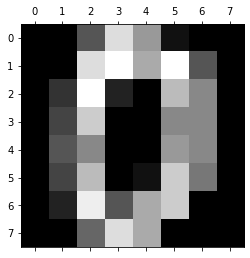

In [40]:
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[0])
plt.show()

Neural networks perform better on normalized input. So, let's calculate a mean value and a standard deviation to perform normalization

In [41]:
X, Y = digits.data, digits.target
X.shape

(1797, 64)

In [42]:
X = np.reshape(X, (1797, 8, 8))
MV = X.mean(axis=0)
Stdev = np.sqrt(np.power(X - MV, 2).mean(axis=0) + 1e-10)
X = (X - MV) / Stdev

Creating train/test split and forming a simple network with three conv layers and LeakyRelu as an activation function. 

In this notebook we are not focused on finding the best model, so we don't do train/validation split and just run 2000 batches of 8 images each and check the result.

In [43]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=100, random_state = 42)

In [44]:
NNConv = Network_multiclass([ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             ConvLayer(pad = True), LeakyRelu(alpha=0.2), 
                             Flatten(), Linear(64, 30), LeakyRelu(alpha=0.2), Linear(30, 10), Softmax()])
train_network_conv(NNConv, train_X, train_Y, lr = 0.03, criterion = 0.1, max_iter = 2000, debug = 0)

iteration 0, average_loss = 26.763306617736816
iteration 67, average_loss = 19.835076151887385
iteration 134, average_loss = 13.182710380641378
iteration 201, average_loss = 10.369829744034773
iteration 268, average_loss = 9.12194663431631
iteration 335, average_loss = 7.423021041195967
iteration 402, average_loss = 6.366991634197323
iteration 469, average_loss = 4.966766400112278
iteration 536, average_loss = 5.894840498353865
iteration 603, average_loss = 6.830703365782879
iteration 670, average_loss = 3.9237614766926283
iteration 737, average_loss = 3.902878870824301
iteration 804, average_loss = 5.220067508033055
iteration 871, average_loss = 4.029189876779572
iteration 938, average_loss = 6.151420125749912
iteration 1005, average_loss = 4.041587711269675
iteration 1072, average_loss = 3.406731936777214
iteration 1139, average_loss = 5.2933398413088115
iteration 1206, average_loss = 3.0118196688729872
iteration 1273, average_loss = 4.750115020320189
iteration 1340, average_loss = 3

Let's check if the model gives us any positive result. The classes are imbalanced so we will take macro-averages for precision and recall

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
Y_hat = NNConv.forward(test_X)
Y_hat = np.argmax(Y_hat, axis = 1)
accuracy_score(test_Y, Y_hat), precision_score(test_Y, Y_hat, average = "macro"), recall_score(test_Y, Y_hat, average = "macro")

(0.87, 0.9247222222222222, 0.8650507825507827)

In [46]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(test_Y, Y_hat)

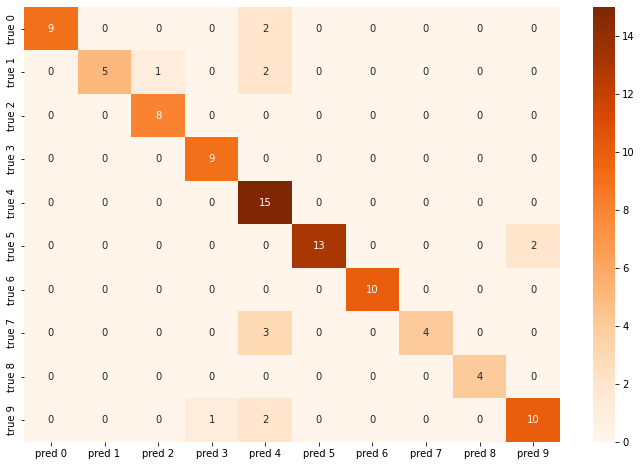

In [47]:
from string import ascii_uppercase
from pandas import DataFrame
import seaborn as sn
from sklearn.metrics import confusion_matrix

lines = ["true "+str(i) for i in range(10)]
columns = ["pred "+str(i) for i in range(10)]
conf_df = DataFrame(conf, index=lines, columns=columns)
plt.figure(figsize = (12,8))
ax = sn.heatmap(conf_df, cmap='Oranges', annot=True)

The results are not bad. Macro precision 0.92 is quite well for such a simple network. Confusion matrix gives us realistic results: 1 and 7 are mixed with 4 and they really look the same in hand-writing, 5 is mixed with 9, 9 is mixed with 3 and 4- same, they are very alike especially in such a low resolution.

Let's give it a try and check what activations look like after the first and the second convolutions:

<Figure size 432x288 with 0 Axes>

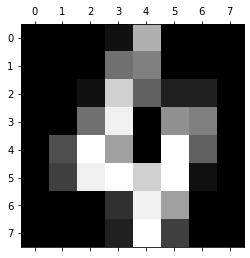

In [48]:
plt.gray()
plt.matshow(digits.images[4])
plt.show()

In [49]:
conv_img = NNConv.layers[0].forward(digits.images[4])

<Figure size 432x288 with 0 Axes>

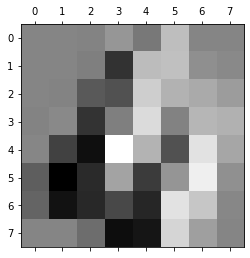

In [50]:
plt.gray()
plt.matshow(conv_img)
plt.show()

In [51]:
conv_conv_img = NNConv.layers[2].forward(conv_img)

<Figure size 432x288 with 0 Axes>

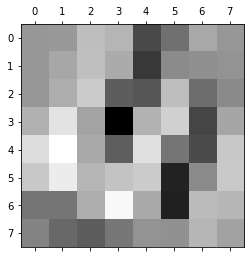

In [52]:
plt.gray()
plt.matshow(conv_conv_img)
plt.show()

### 3. Batch Normalization

Sergey Ioffe and Christian Szegedy in their famous paper "Batch Normalization: Accelerating Deep Network Training by
Reducing Internal Covariate Shift" https://arxiv.org/pdf/1502.03167.pdf suggest to perform a normalization of every batch so that the input to the next layer always has zero mean and unit variance. This shall lead to network regularization, speed up training and allow using higher learning rates. To achieve this, we need to implement BatchNorm layer that calculates means and variances of every batch for every pixel (in the direction along the batch) and then using this per-batch parameters performs normalization. 

Doing such a normalization, however, can make harm to the network. E.g., by supplying normalized values to sigmoid nonlinearity we will shift it into a linear regime. To fix this or "to restore the representation power of the network" as it is said in the paper, the authors introduce two learnable parameters gamma and beta that provide a scale and a shift to the normalized input. Let's implement batch normalization layer and check if it helps us get better results.

Compared to other layers BatchNorm layer is different in the sence that it has two modes - training mode and inference mode. The difference is that in inference mode normalization is done using not per-batch statistics but per training set statistics. These statistics, namely, mean and variance, are calculated during training as a moving average with momentum that is set up as a parameter at layer initialization.

In [53]:
class BatchNorm:
    """ Batch normalization layer (as per https://arxiv.org/pdf/1502.03167.pdf)
    Normalizes, i.e. achieves zero mean and standard deviation of 1 using mini-batch statistics for every pixel along the batch direction.
    
    Attibutes and parameters:
    self.inference - whether the layer is in inference mode
    self.m and self.v - mean and variance of the whole training set calculated as moving average during training
    self.g and self.b - gamma and beta used for scaling and shifting normalized inputs. These parameters are learnable and for each mini-batch
        a gradient step is done, see backward() method.
    self.mu, self.var - mean and variance of a mini-batch. They have the same dimension as input image in a batch as they are calculated per-pixel
    self.momentum - momentum used for moving average calculation
    
    """
    
    
    def __init__(self):
        self.inference = False
        self.g = 1
        self.b = 1
        self.m = 0
        self.v = 0    
        self.mu = None
        self.var = None
        self.X_ = None
        self.X_norm_ = None
        self.momentum = 0.1
        
    def forward(self, X):
        eps = 1e-10
        if not self.inference:
            self.X_ = X
            self.mu = X.mean(axis=0)
            self.var = np.power(X - self.mu, 2).mean(axis = 0)
            
            self.m = (1 - self.momentum) * self.m + self.momentum * self.mu
            self.v = (1 - self.momentum) * self.v + self.momentum * self.var

            X_norm = (X - self.mu) / np.sqrt(self.var + eps)
            self.X_norm_ = X_norm
            return X_norm * self.g + self.b
        
        else:
            return X * self.g / np.sqrt(self.v + eps) + (self.b - self.g * self.m / np.sqrt(self.v + eps))
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        eps = 1e-10
        dldX_norm = upstr_grad * self.g
        
        # remember that self.var is a matrix and self.mu is a matrix, hence dldvar and dldmu are also matrixes.
        # the formulas for gradient calculations are provided in the original paper
        
        dldvar = (dldX_norm * (self.X_ - self.mu) * (-1/2) * np.power(self.var + eps, -3/2)).sum(axis=0)
        dldmu = dldX_norm * (-1) / np.sqrt(self.var + eps).sum(axis=0) + dldvar * 1/self.X_.shape[0] * ((-2) * (self.X_ - self.mu)).sum(axis=0)
        dldX = dldX_norm * 1 / np.sqrt(self.var + eps) + dldvar * 1 / self.X_.shape[0] * 2 * (self.X_ - self.mu) + dldmu * 1 / self.X_.shape[0]
        dldg = (upstr_grad * self.X_norm_).sum(axis=0)
        dldb = upstr_grad.sum(axis=0)
        
        self.g += (-1) * lr * dldg
        self.b += (-1) * lr * dldb
        return dldX

Let's test the new layer by inserting it into our network before every non-linearity

In [54]:
NNConv_batch = Network_multiclass([ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          ConvLayer(pad = True), BatchNorm(), LeakyRelu(alpha=0.2), 
                          Flatten(), Linear(64, 30), BatchNorm(), LeakyRelu(alpha=0.2), Linear(30, 10), Softmax()])

NNConv_batch.train_mode()
train_network_conv(NNConv_batch, train_X, train_Y, lr = 0.003, criterion = 0.1, max_iter = 2000, debug = 0)

iteration 0, average_loss = 31.289167523384094
iteration 67, average_loss = 23.70855657847177
iteration 134, average_loss = 19.39348937425783
iteration 201, average_loss = 17.386007861890203
iteration 268, average_loss = 15.363376134834873
iteration 335, average_loss = 13.624763847353439
iteration 402, average_loss = 11.432722025324365
iteration 469, average_loss = 11.263786274730254
iteration 536, average_loss = 10.29598873042161
iteration 603, average_loss = 9.096814371339397
iteration 670, average_loss = 8.801520224185522
iteration 737, average_loss = 8.293347728382793
iteration 804, average_loss = 7.993773622960518
iteration 871, average_loss = 7.193291402979352
iteration 938, average_loss = 7.90852571555669
iteration 1005, average_loss = 6.394621599679099
iteration 1072, average_loss = 7.359167403050349
iteration 1139, average_loss = 7.99861961633743
iteration 1206, average_loss = 7.235321881971068
iteration 1273, average_loss = 6.570723598009928
iteration 1340, average_loss = 6.7

In [55]:
NNConv_batch.inference_mode()

In [56]:
Y_hat = NNConv_batch.forward(test_X)
Y_hat = np.argmax(Y_hat, axis = 1)

In [57]:
accuracy_score(test_Y, Y_hat), precision_score(test_Y, Y_hat, average = "macro"), recall_score(test_Y, Y_hat, average = "macro")

(0.93, 0.9401551226551227, 0.9191233766233766)

The results look better but obviously this topic deserves more research as we need to do more tests with different learning rates, train/val split and more complex dataset with three channel inputs.